In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
df_network = pd.read_csv("../data/youtubers_networks_metrics.csv")
df_cliques = pd.read_csv("../data/youtubers_networs_clique_metrics.csv").drop("max_clique_idx", axis=1)

In [3]:
df_metrics = pd.merge(df_network, df_cliques, on="youtuber")
df_metrics.head()

,num_nodes,num_edges,avg_degree,avg_clustering_coef,modularity,coverage,performance,largest_community,number_of_communities,youtuber,num_max_cliques,max_clique_size,avg_clique_size,median_clique_size,avg_degree_clique,avg_clustering_coef_clique
0,24987,125165,10.018410,0.024277,0.650751,0.778700,0.857285,7457,14,felipeneto,38007,56,16.454785,16.0,19.969580,0.030700
1,12827,37520,5.850160,0.016486,0.754071,0.866018,0.865387,3477,14,enaldinho,2591,32,10.387881,10.0,22.757381,0.013837
2,19978,72053,7.213235,0.040755,0.901826,0.963291,0.952666,1711,31,geleia0,5558,30,8.259086,6.0,15.295712,0.050834
3,18107,68117,7.523831,0.014152,0.843106,0.898381,0.946336,1726,24,RobinHoodGamer1,6812,25,8.874339,8.0,17.584979,0.023733
4,13808,149033,21.586472,0.010457,0.523720,0.824321,0.620891,7999,8,rezendeevil,228234,73,44.931080,46.0,36.016299,0.010498


In [11]:
def apply_pca(df, n_components=2):
    features = df.drop(columns=['youtuber'])  
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(scaled_features)
    
    pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(n_components)])
    pca_df['youtuber'] = df['youtuber'].values
    return pca_df, pca

def apply_kmeans(df, n_clusters=5):
    features = df.drop(columns=['youtuber'])  
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans_values = kmeans.fit_predict(features)
    df_metrics['kmeans_cluster'] = kmeans_values
    return df_metrics, kmeans_values

def apply_hierarchical(df_metrics, method='single'):
    linked = linkage(df_metrics.drop(columns=['youtuber']), method=method)
    return linked

In [70]:
def visualize_pca(pca_df):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='youtuber', data=pca_df, palette='Set1', s=100, legend=False)
    for i, txt in enumerate(pca_df['youtuber']):
        plt.annotate(txt, (pca_df['PC1'][i], pca_df['PC2'][i]), fontsize=9, ha='right')
    plt.title('PCA Visualization')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

def visualize_kmeans(pca_df, df_metrics):
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x='PC1', y='PC2', hue='kmeans_cluster', data=df_metrics, palette='Set1', s=100)

    for i, txt in enumerate(pca_df['youtuber']):
        plt.annotate(txt, (pca_df['PC1'][i], pca_df['PC2'][i]), 
                     fontsize=10, 
                     textcoords='offset points',
                     xytext=(-15, -13)
                     )

    plt.title('K-means Clustering on PCA Components')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

def visualize_dendrogram(linked, labels):
    plt.figure(figsize=(10, 7))
    dendrogram(linked, labels=labels, leaf_rotation=90, leaf_font_size=10)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.ylabel("Distance")
    plt.xticks(rotation=45)  # Tilt x-axis labels 45 degrees
    plt.show()


def visualize_clustering_comparison(pca_df, df_metrics, kmeans_values, linked, n_clusters_hierarchical=4):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    scatter_kmeans = plt.scatter(x="PC1", y="PC2", data=df_metrics, c=kmeans_values, cmap='plasma', s=100)
    plt.title('K-means Clustering')
    plt.xlabel('PC1')
    plt.ylabel('PC2')

    for i, txt in enumerate(pca_df['youtuber']):
        plt.text(pca_df['PC1'][i], pca_df['PC2'][i], txt, fontsize=9, ha='left')

    clusters_hierarchical = fcluster(linked, t=n_clusters_hierarchical, criterion='maxclust')  
    
    plt.subplot(1, 2, 2)
    scatter_hierarchical = plt.scatter(x="PC1", y="PC2", data=df_metrics, c=clusters_hierarchical, cmap='plasma', s=100)
    plt.title('Hierarchical Clustering')
    plt.xlabel('PC1')
    plt.ylabel('PC2')

    for i, txt in enumerate(pca_df['youtuber']):
        plt.text(pca_df['PC1'][i], pca_df['PC2'][i], txt, fontsize=9, ha='left')

    plt.tight_layout()
    plt.show()

In [13]:
pca_df, pca_model = apply_pca(df_metrics)
df_metrics, kmeans_values = apply_kmeans(df_metrics)
df_metrics = pd.merge(pca_df, df_metrics, on="youtuber")
linked = apply_hierarchical(df_metrics)

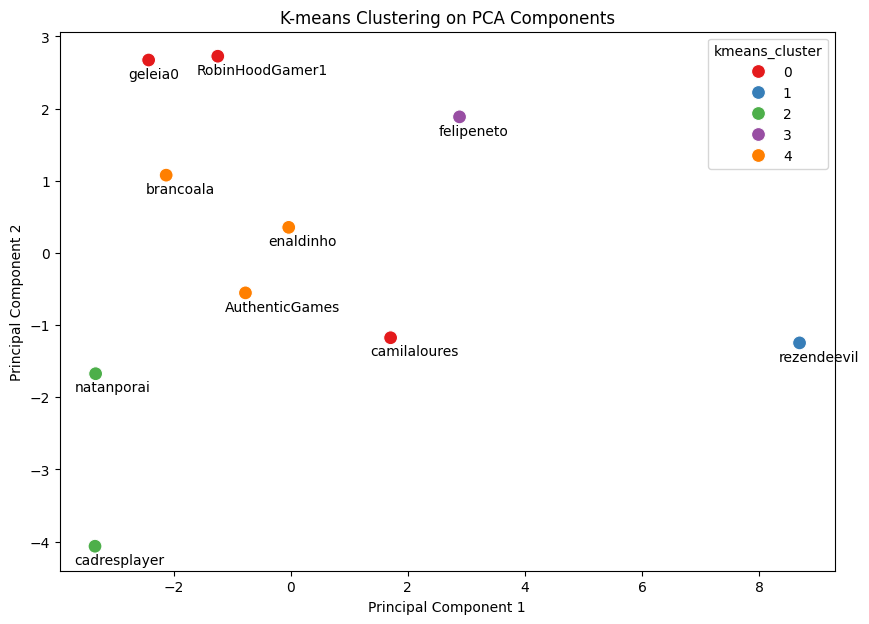

In [71]:
visualize_kmeans(pca_df, df_metrics)

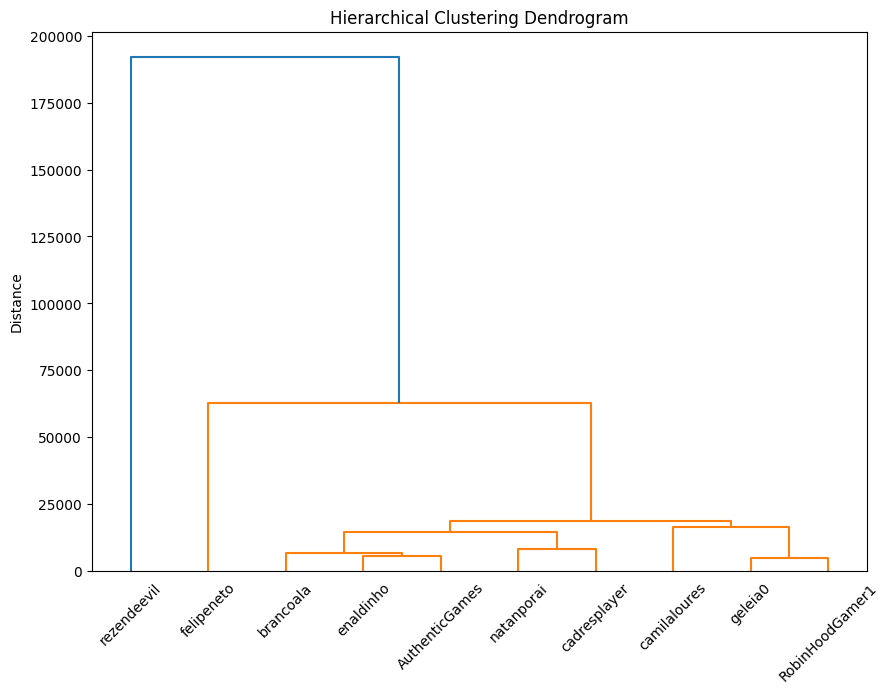

In [21]:
# visualize_dendrogram(linked, labels=df_metrics['youtuber'].values)
visualize_dendrogram(linked, labels=df_metrics['youtuber'].values)
clusters_hierarchical = fcluster(linked, t=4, criterion='maxclust')  

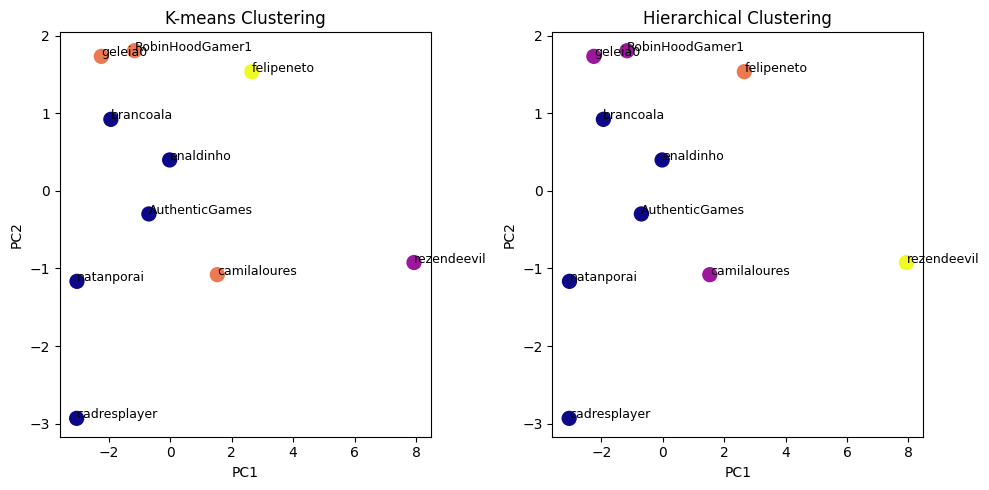

In [98]:
visualize_clustering_comparison(pca_df, df_metrics, kmeans_values, linked)